In [27]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Load the Excel file into a DataFrame
data = pd.read_excel('data/INE_IPC.xlsx')



In [28]:
data.rename(columns={
    'Unnamed: 0': 'time',
    '    Índice general': 'index_general',
    '    01 Alimentos y bebidas no alcohólicas': 'food_beverages',
    '    02 Bebidas alcohólicas y tabaco': 'alc_tobacco',
    '    03 Vestido y calzado': 'clothing_footwear',
    '    04 Vivienda, agua, electricidad, gas y otros combustibles': 'housing_utilities',
    '    05 Muebles, artículos del hogar y artículos para el mantenimiento corriente del hogar': 'furniture_household',
    '    06 Sanidad': 'health',
    '    07 Transporte': 'transport',
    '    08 Comunicaciones': 'communications',
    '    09 Ocio y cultura': 'leisure_culture',
    '    10 Enseñanza': 'education',
    '    11 Restaurantes y hoteles': 'restaurants_hotels',
    '    12 Otros bienes y servicios': 'other_goods_services'
}, inplace=True)

data['time'] = pd.to_datetime(data['time'], format='%YM%m')



In [29]:
def plot_inflation(data, inflation_type):
    title = inflation_type
    plt.figure(figsize=(14, 7))

    # Line plot of inflation over time
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], data[inflation_type], marker='o', color='r')
    plt.xlabel('Time')
    plt.ylabel(inflation_type.replace('_', ' ').title())
    plt.title(f'{title} Over Time')
    plt.grid(True)

    # Histogram of inflation
    plt.subplot(2, 1, 2)
    plt.hist(data[inflation_type].dropna(), bins=30, edgecolor='k', color='r')
    plt.xlabel(inflation_type.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {title}')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_acf_pacf(data,variable,lag):
    plt.figure(figsize=(14, 7))
    # Autocorrelation plot
    plt.subplot(2, 1, 1)
    plot_acf(data[variable].dropna(), lags=lag, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of {variable.replace("_", " ").title()}')
    plt.grid(True)

    #Partial autocorrelation plot
    plt.subplot(2, 1, 2)
    plot_pacf(data[variable].dropna(), lags=lag, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of {variable.replace("_", " ").title()}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [31]:
### Funcions

# plot lineplot and histogram
def plot_eda(data, feature, color='skyblue', transform_func=None):
    plt.figure(figsize=(18, 6))

    # Line plot of the feature over time
    plt.subplot(1, 3, 1)
    plt.plot(data['time'], data[feature], marker='.', color=color)
    plt.xlabel('Time')
    plt.ylabel(feature.replace('_', ' ').title())
    plt.title(f'{feature.replace("_", " ").title()} Over Time')
    plt.grid(True)

    # Histogram of the feature
    plt.subplot(1, 3, 2)
    plt.hist(data[feature].dropna(), bins=30, edgecolor='k', color=color, density=True)

    mean = data[feature].mean()
    std = data[feature].std()
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    p = np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi))

    plt.plot(x, p, color='red', linewidth=2)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Density')
    plt.title(f'Histogram + Normal Dist of {feature.replace("_", " ").title()}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()



## Original Data General index

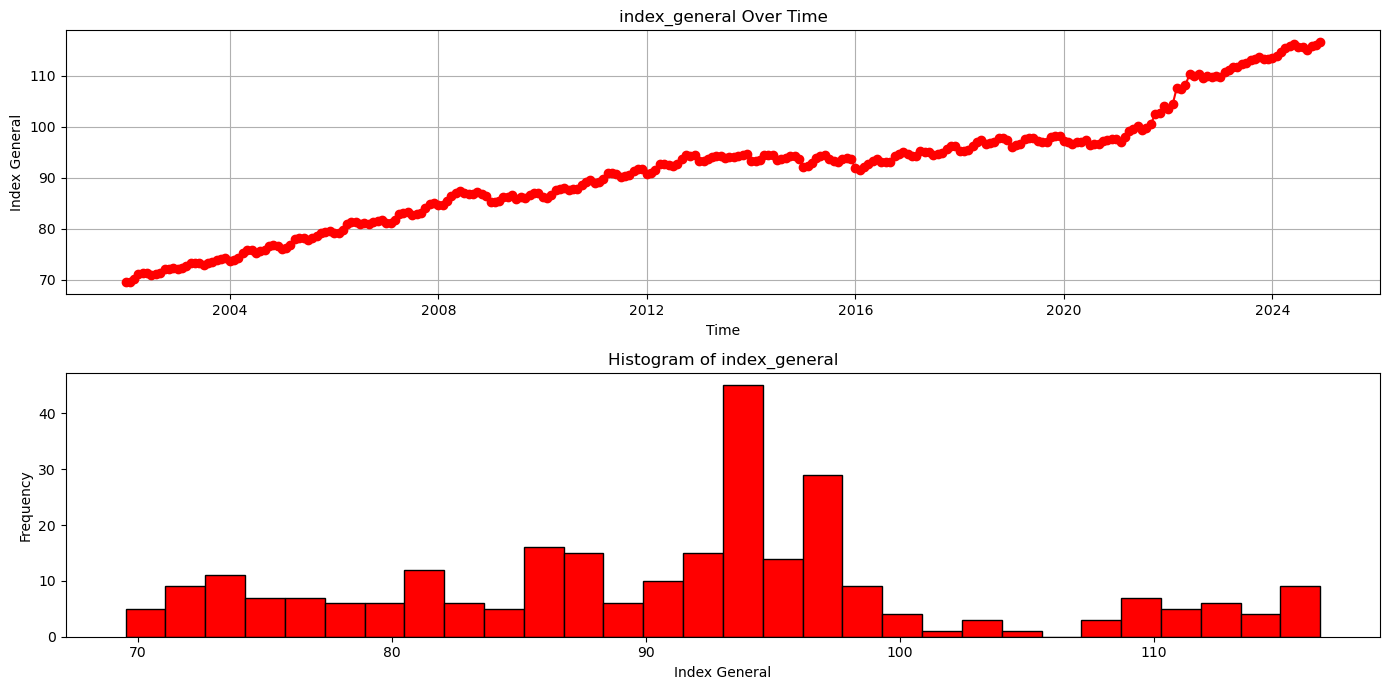

In [32]:
plot_inflation(data,"index_general")

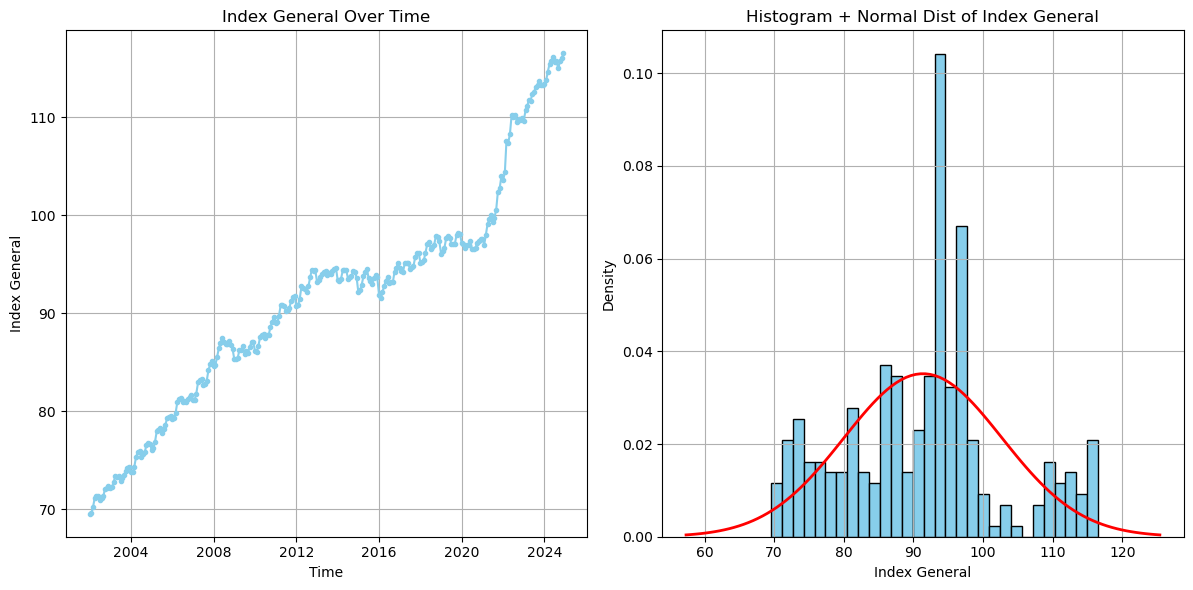

In [33]:
plot_eda(data,"index_general")

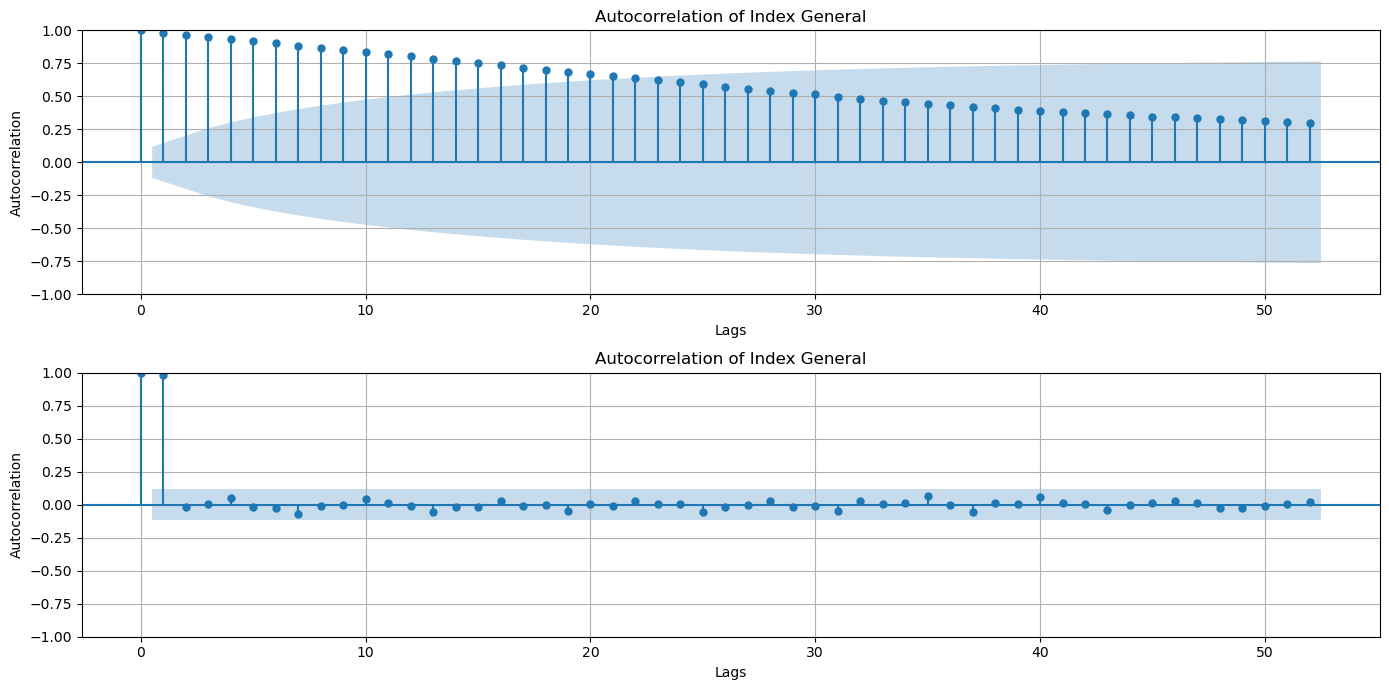

In [34]:
plot_acf_pacf(data,"index_general",52)

## Monthly inflation

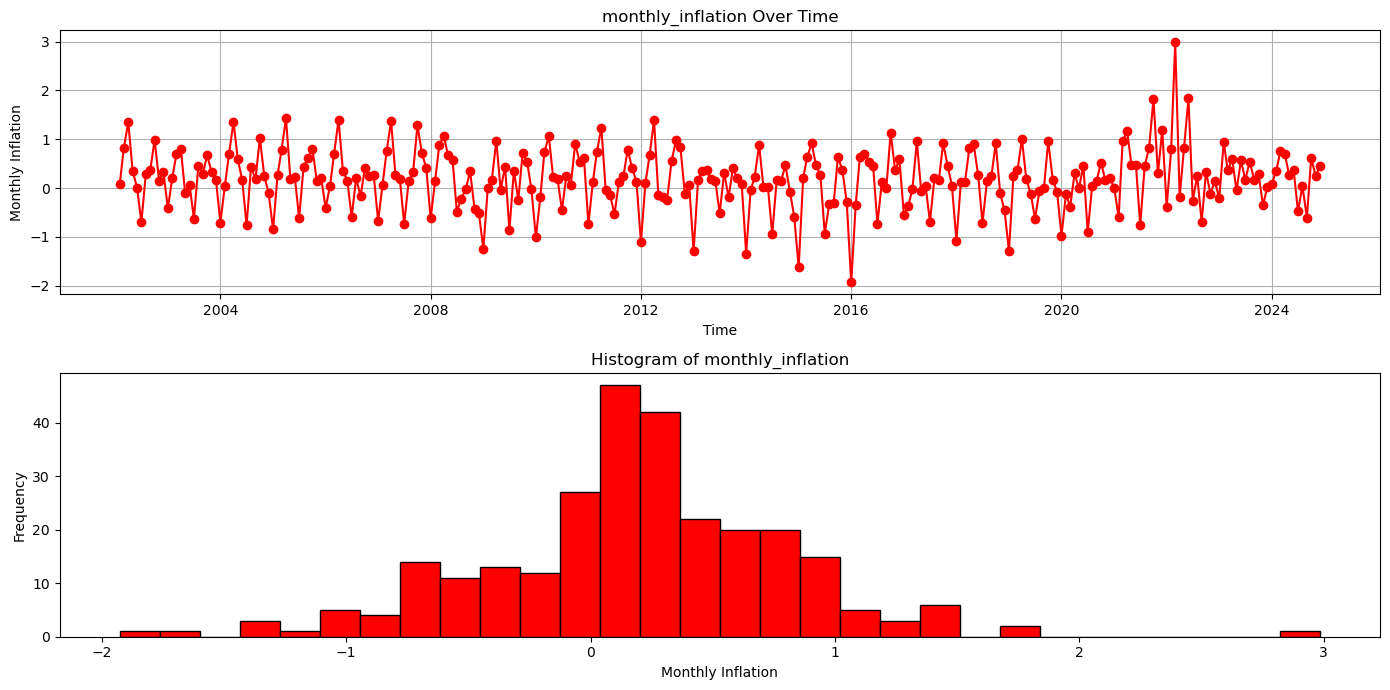

In [35]:
# Calculate the monthly inflation
data['monthly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(1)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['monthly_inflation'], inplace=True)

plot_inflation(data, 'monthly_inflation')


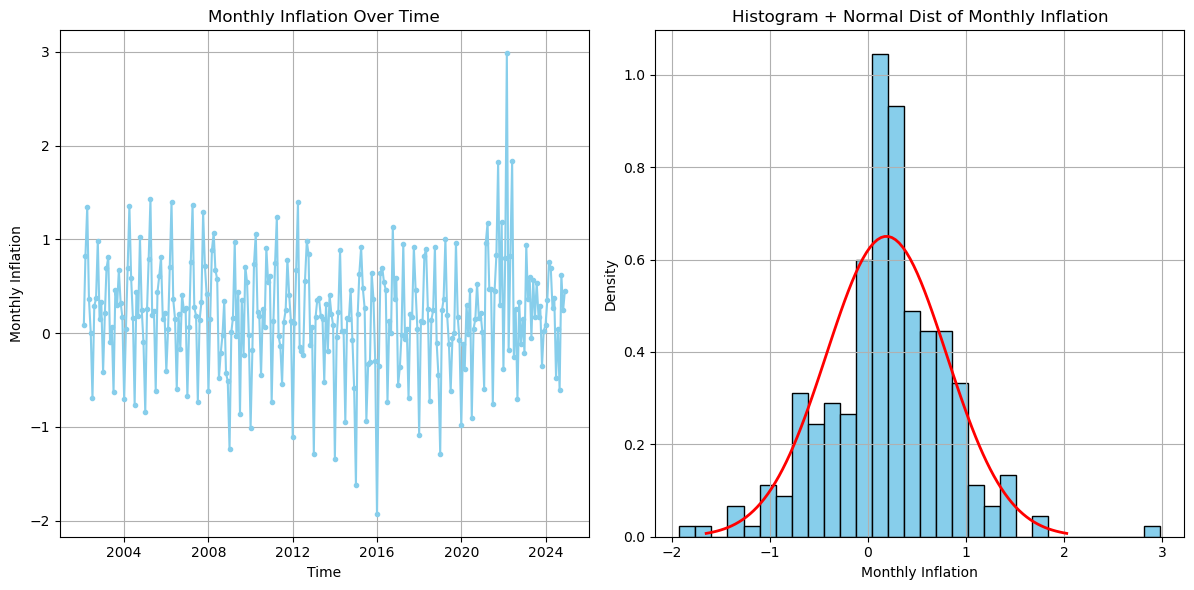

In [36]:
plot_eda(data,"monthly_inflation")

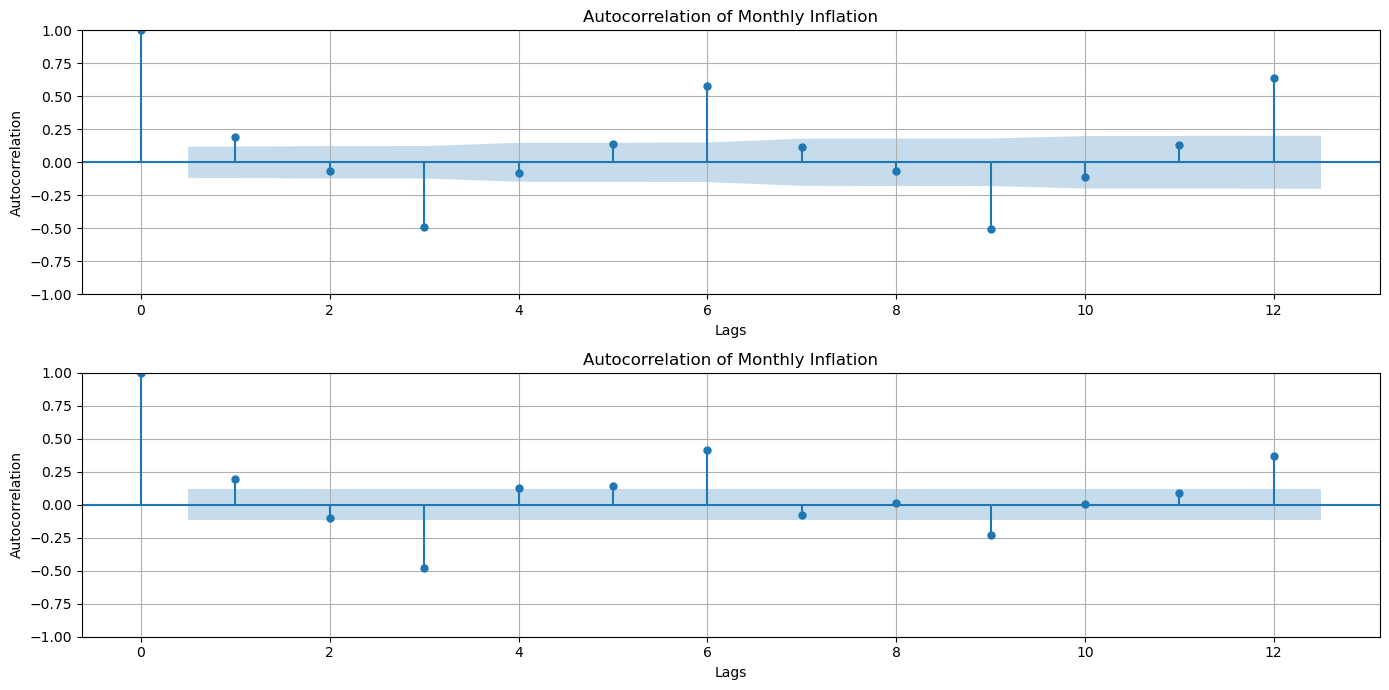

In [37]:
plot_acf_pacf(data,"monthly_inflation",12)

In [38]:
# Perform the Dickey-Fuller test
result = adfuller(data['monthly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.3858981155284065
p-value: 0.011449101151194113


## Yearly inflation

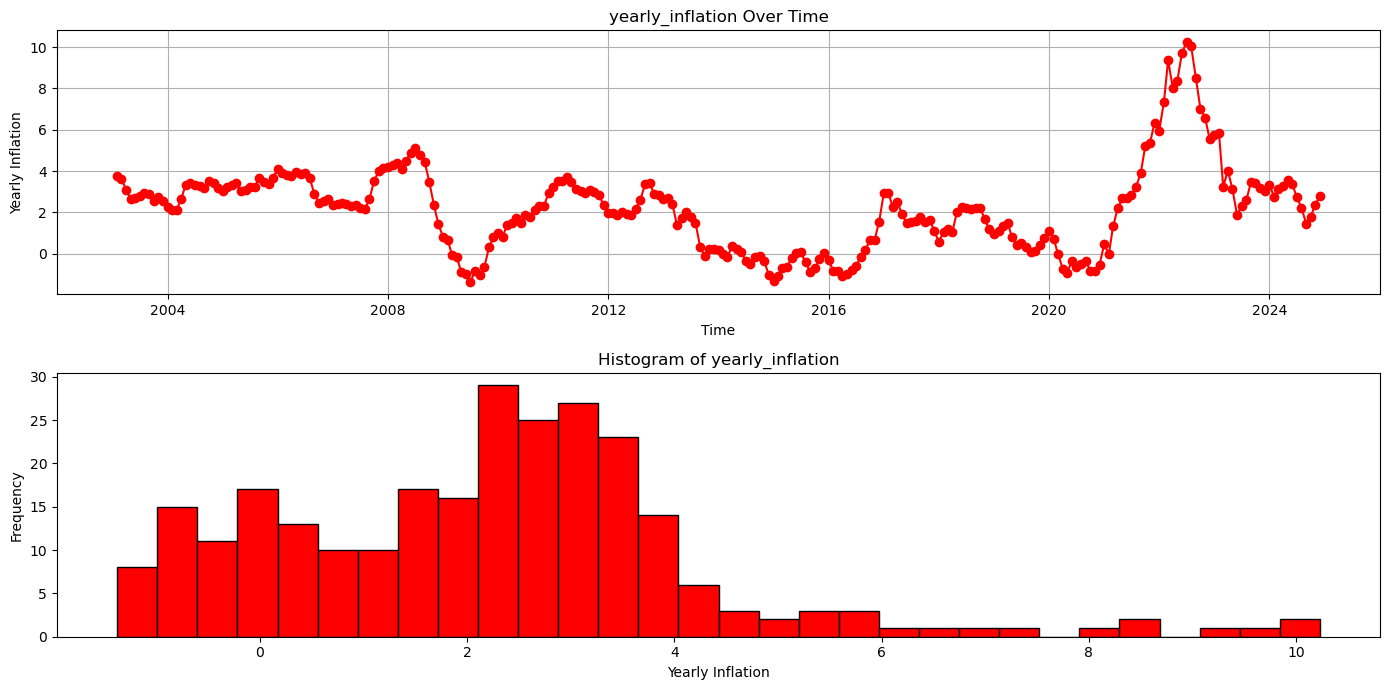

In [39]:
### Check seasonality patterns

# Calculate the monthly inflation
data['yearly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(12)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['yearly_inflation'], inplace=True)

plot_inflation(data, 'yearly_inflation')

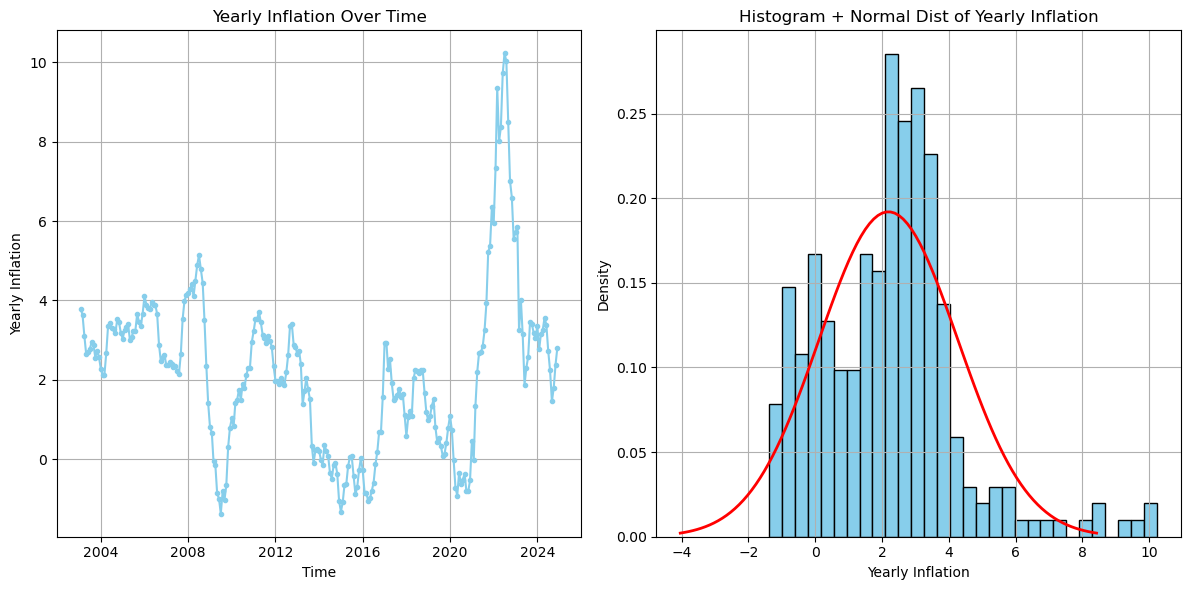

In [40]:
plot_eda(data,"yearly_inflation")

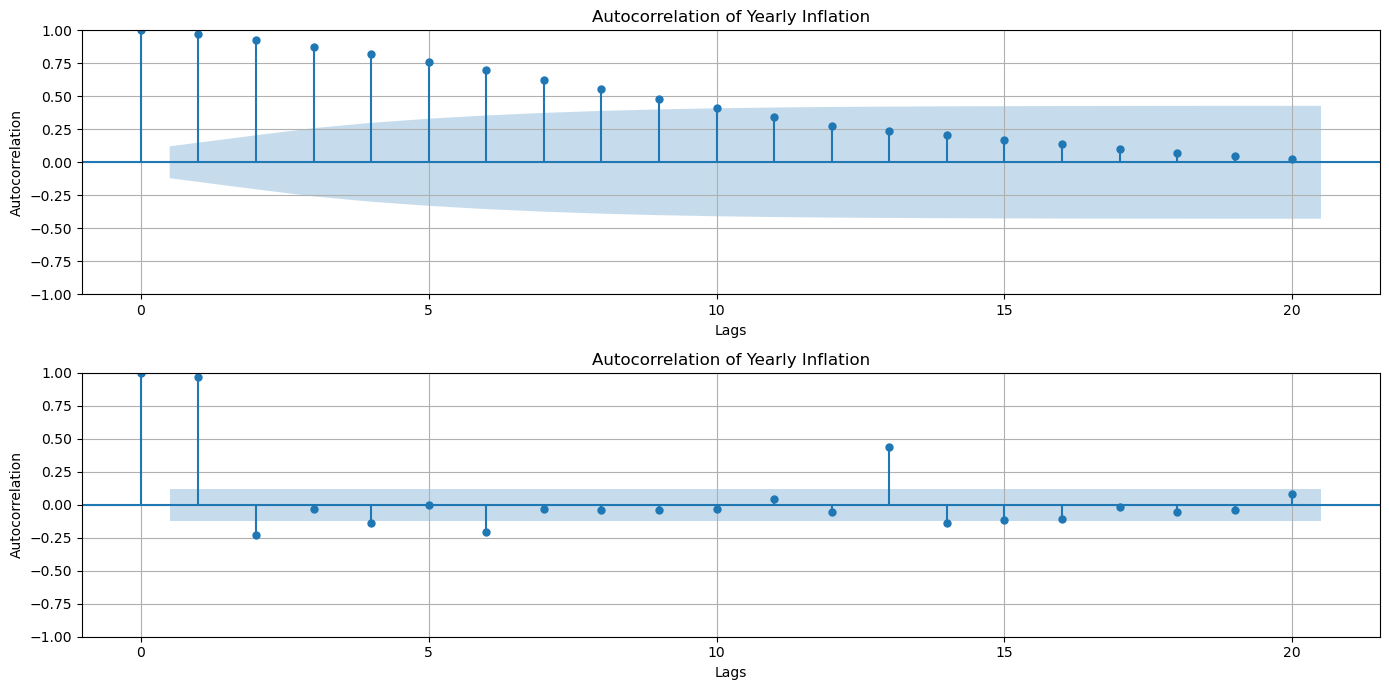

In [41]:
plot_acf_pacf(data,"yearly_inflation",20)

In [42]:
# Perform the Dickey-Fuller test
result = adfuller(data['yearly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.893530055567397
p-value: 0.04610555354885436


AR(1)

In [45]:
def ar_test_model(data,feature,dif=0,p=1,q=0):
    # Fit the AR(lag) model
    model = ARIMA(data[feature], order=(p,dif,q))
    
    model_fit = model.fit()
    
    print(model_fit.summary())

    model_fit.plot_diagnostics(figsize=(15,12))
    plt.show()
    return model_fit


c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -195.672
Date:                Sat, 08 Mar 2025   AIC                            397.343
Time:                        13:59:25   BIC                            408.060
Sample:                             0   HQIC                           401.650
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3991      0.980      2.448      0.014       0.478       4.320
ar.L1          0.9676      0.010     94.080      0.000       0.947       0.988
sigma2         0.2566      0.014     18.995      0.0

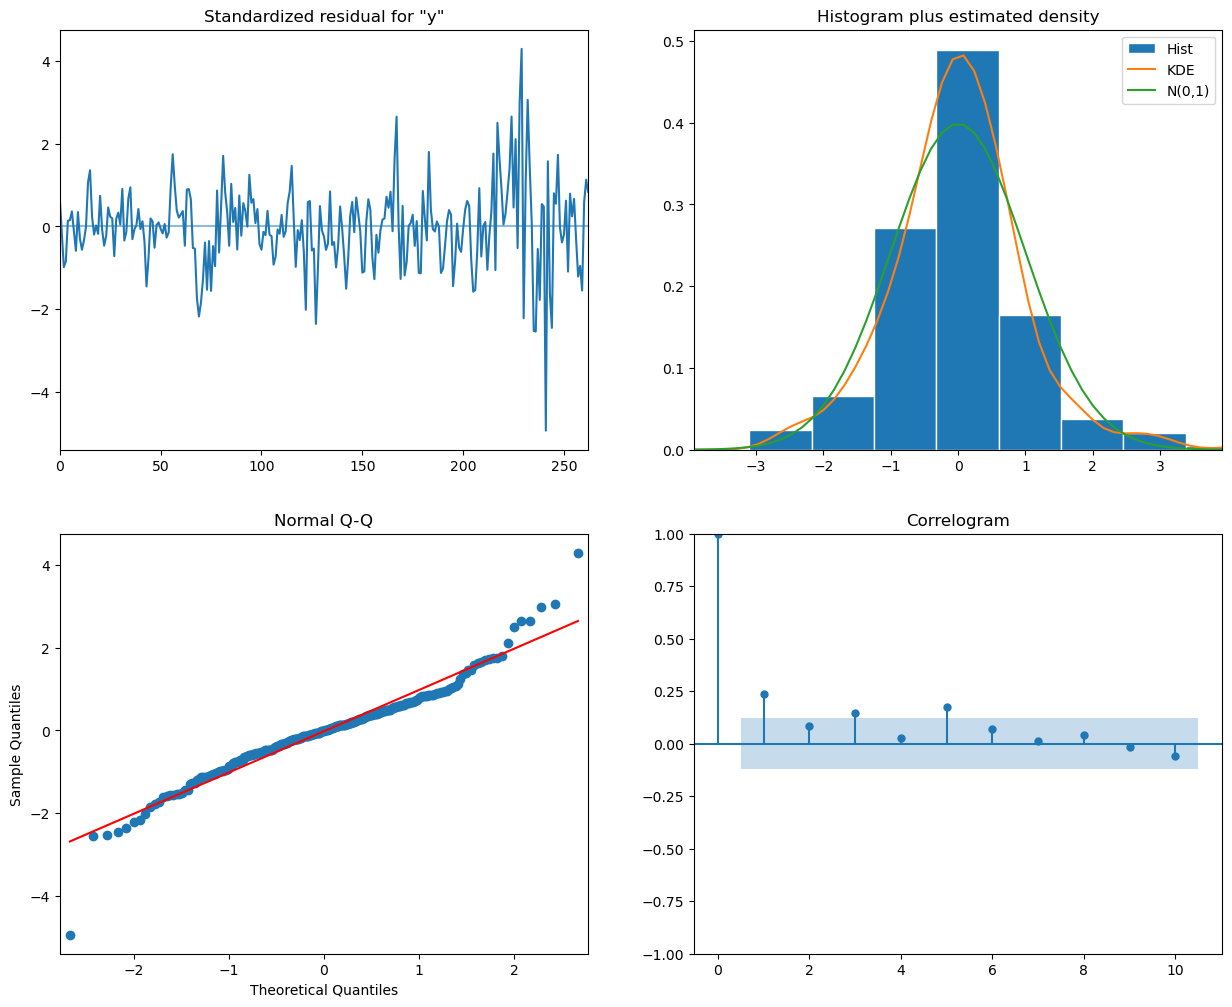

In [53]:
model_ar_1 = ar_test_model(data,"yearly_inflation",p=1)

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -187.595
Date:                Sat, 08 Mar 2025   AIC                            383.190
Time:                        13:59:38   BIC                            397.479
Sample:                             0   HQIC                           388.933
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3399      0.815      2.872      0.004       0.743       3.937
ar.L1          1.2045      0.035     34.067      0.000       1.135       1.274
ar.L2         -0.2438      0.037     -6.628      0.0

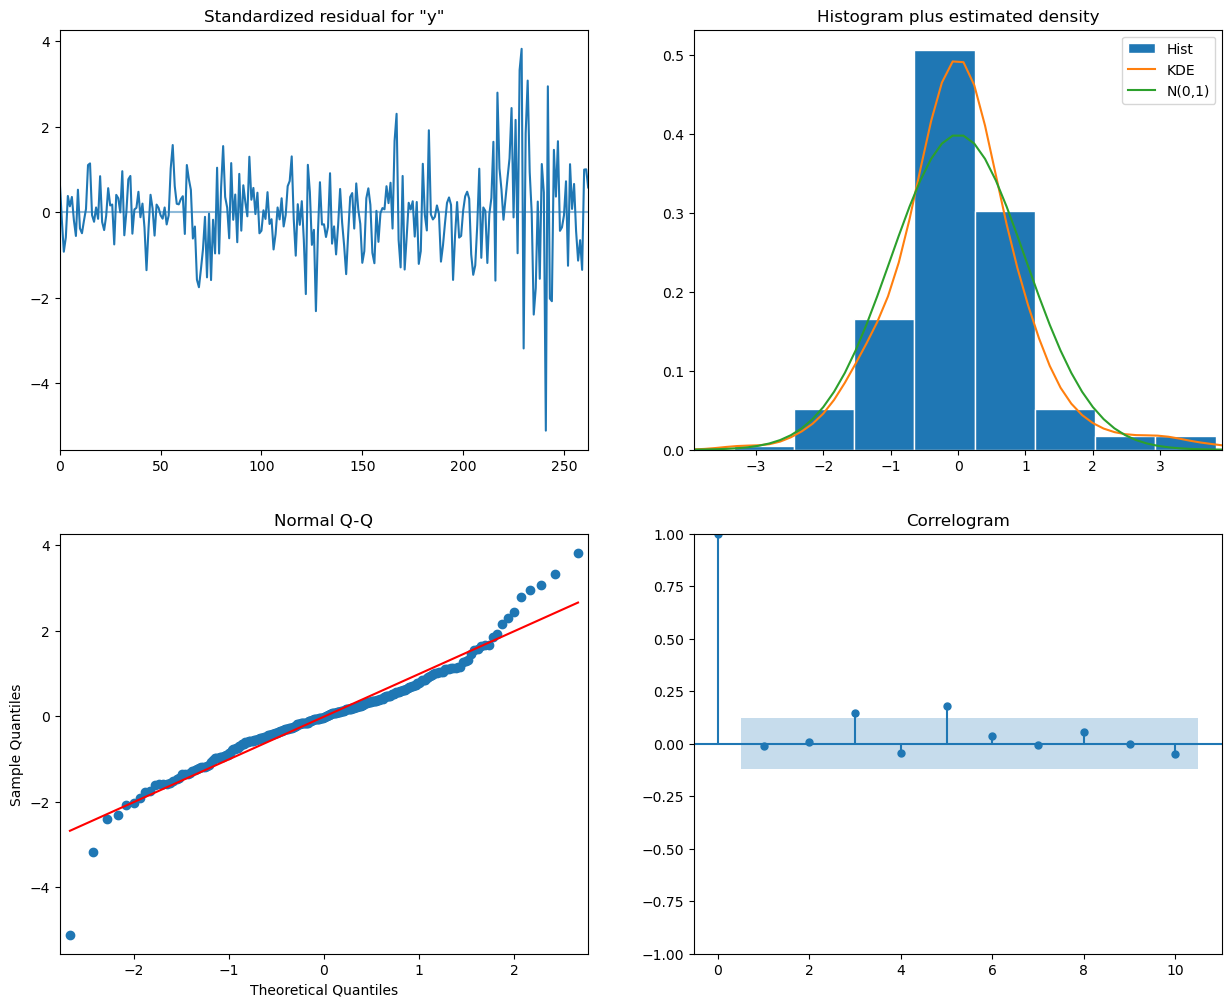

In [54]:
model_ar_2 = ar_test_model(data,"yearly_inflation",p=2)

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -187.309
Date:                Sat, 08 Mar 2025   AIC                            384.618
Time:                        13:59:44   BIC                            402.479
Sample:                             0   HQIC                           391.796
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3364      0.786      2.971      0.003       0.795       3.878
ar.L1          1.1932      0.035     33.801      0.000       1.124       1.262
ar.L2         -0.1875      0.056     -3.322      0.0

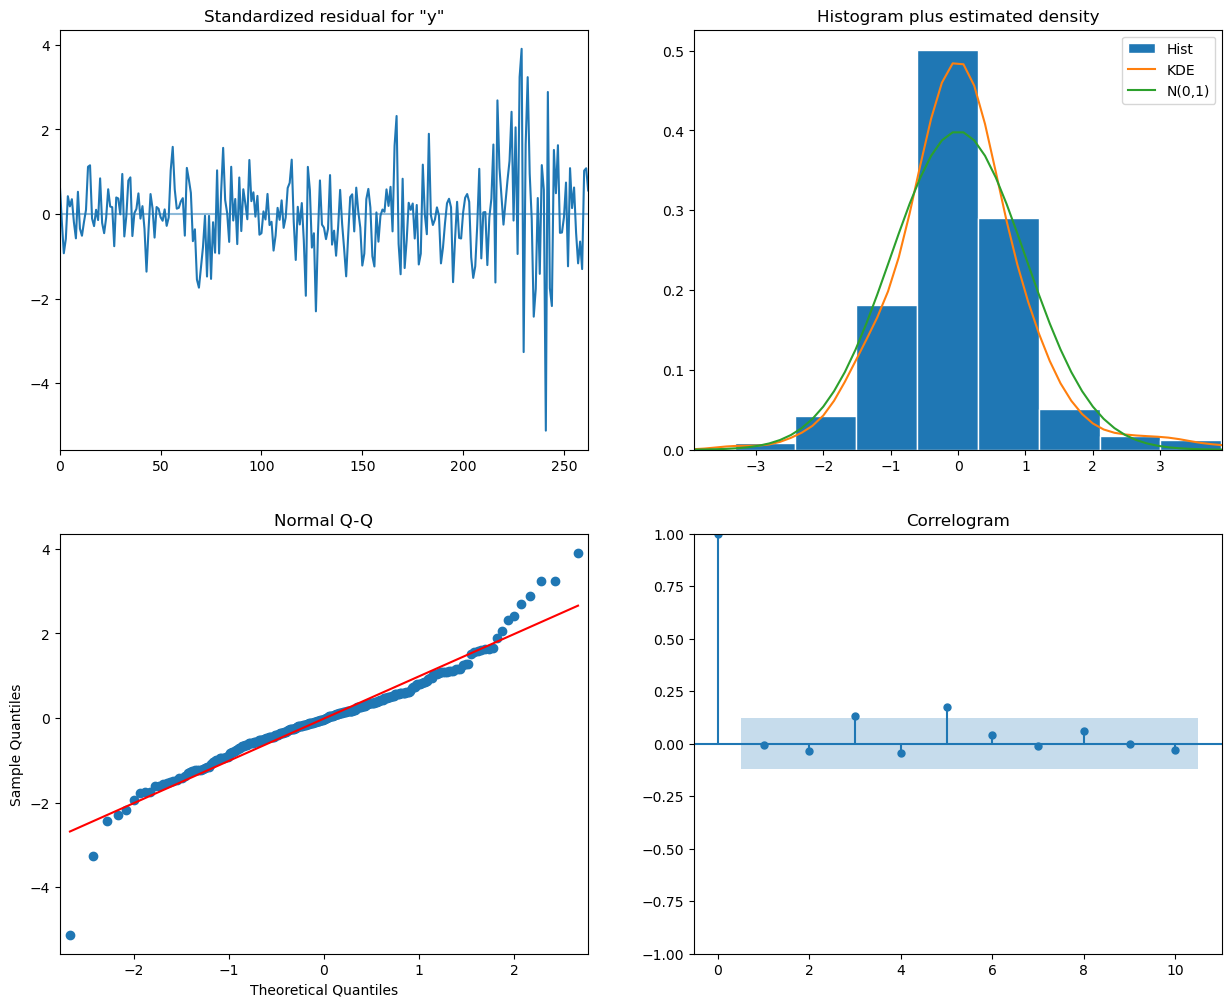

In [55]:
ar_test_model(data,"yearly_inflation",p =3)

In [52]:
from pmdarima import auto_arima

auto_model = auto_arima(data["yearly_inflation"], seasonal=False, trace=True, stepwise=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=386.465, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1329.540, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=399.160, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=389.005, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=385.866, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=387.057, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=386.337, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=388.059, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=379.182, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=384.318, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=383.190, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 s

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -184.591
Date:                Sat, 08 Mar 2025   AIC                            379.182
Time:                        14:00:15   BIC                            397.043
Sample:                             0   HQIC                           386.360
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2859      0.552      4.143      0.000       1.205       3.367
ar.L1          1.8221      0.064     28.636      0.000       1.697       1.947
ar.L2         -0.8391      0.061    -13.868      0.0

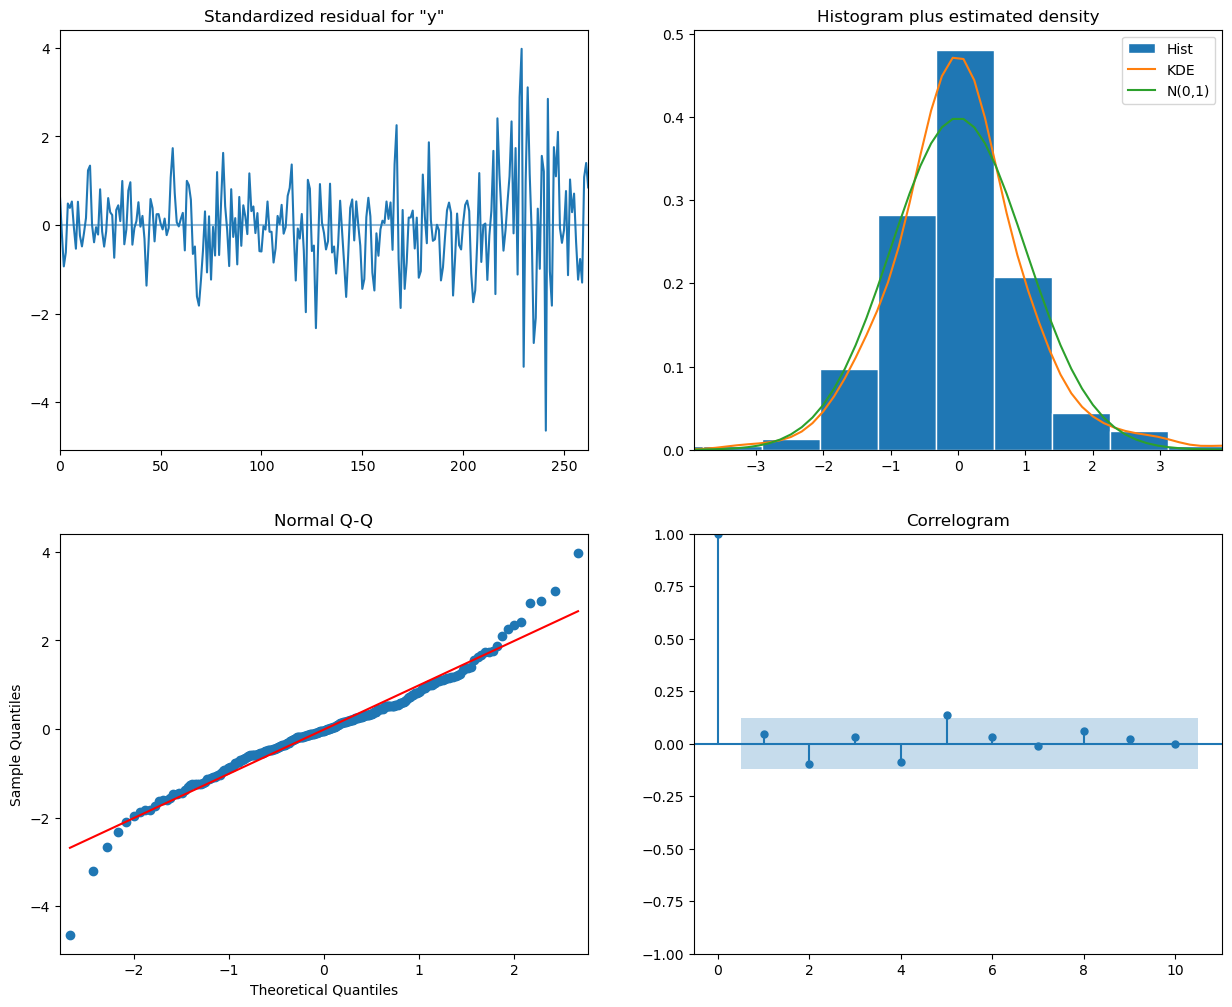

In [57]:
ar_test_model(data,"yearly_inflation",p=2,dif=0,q=1)